## IMPORT REQUIRED PACKAGES {-}









In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Preprocessing Data {-}

- From the dataset choosen, it is clear that X1 to Z4 are the accelerometer readings and the remaining are categorical and are specific to the individual on which the accelerometer readings are taken like gender, age, etc. So, we decided to use a Deep Neural Network to predict the probable value to any of the X1 to Z4 variables based on the knowledge of training data. 

## ReadData & Preprocess {-}

In [65]:
X=pd.read_csv('/Users/harsha/Desktop/myProjects/Fall2020-Local/ML/CS536FinalProject/ML-FinalProject/Datasets/Train_data.csv', encoding = 'ISO-8859-1')
selFeat=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']
X=X[selFeat]
Xarr=X.to_numpy()
arr = np.random.binomial(1, 0.5, X.shape)
indices=np.where(arr==0)
Xtransformed=Xarr.astype('float')
Xtransformed[indices]=np.nan
XtransDataframe=pd.DataFrame(Xtransformed,columns=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])
Xtrain = XtransDataframe
ytrain=pd.DataFrame(Xarr,columns=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])
Xtrain=Xtrain.to_numpy()
ytrain=ytrain.to_numpy()
Xtrain_orig_nan=Xtrain.copy()
ytrain_orig_nan=ytrain.copy()
X_train_nan=Xtrain_orig_nan[:99379,:].copy()
X_test_nan=Xtrain_orig_nan[99380:132000,:].copy()
X_val_nan=Xtrain_orig_nan[132001:132507,:].copy()
Y_train_nan=ytrain_orig_nan[:99379,:].copy()
Y_test_nan=ytrain_orig_nan[99380:132000,:].copy()
Y_val_nan=ytrain_orig_nan[132001:132507,:].copy()
X_train=X_train_nan.copy()
X_test=X_test_nan.copy()
X_val=X_val_nan.copy()
Y_train=Y_train_nan.copy()
Y_test=Y_test_nan.copy()
Y_val=Y_val_nan.copy()

col_mean = np.nanmean(X_train, axis=0)
# print(col_mean)
#Find indices that you need to replace
inds = np.where(np.isnan(X_train))
#Place column means in the indices. Align the arrays using take
X_train[inds] = np.take(col_mean, inds[1])
X_train[0]

col_mean = np.nanmean(X_test, axis=0)
# print(col_mean)
#Find indices that you need to replace
inds = np.where(np.isnan(X_test))
#Place column means in the indices. Align the arrays using take
X_test[inds] = np.take(col_mean, inds[1])
# print(X_train)
X_test[0]

col_mean = np.nanmean(X_val, axis=0)
# print(col_mean)
#Find indices that you need to replace
inds = np.where(np.isnan(X_val))
#Place column means in the indices. Align the arrays using take
X_val[inds] = np.take(col_mean, inds[1])
# print(X_train)
X_val[0]

Y_train = Y_train.T.copy()
Y_val = Y_val.T.copy()
Y_test = Y_test.T.copy()

## Model Description {-}
### Input Space {-}
- The Feature samples with 50% missing data filled as the column's mean<br>

### Output Space {-}
- The prediction for all the features close to true values

### Algorithm {-}
- We are using a Deep Neural Network which learns to impute all the features from X1 through Z4 (accelerometer readings).
- We are training the Neural Network by passing X1 through Z4 (say, m samples) with few feature values being missed and the missed values are filled as mean of the column as the input.
- One of the main reason to fill in mean values for missing values in the input stage for NN is to make it build a relation between the true value and mean value. We tried an experiment with zero as the replace value for missing data but as it would be same for every missing value, it is just tough for the neural net to make a relation between all zeros and individual true values and as expected the results were not that great. 
- The results are pretty fascinating when we used mean as the replace value.
- The cost function is between the True Values of X1 through Z4 and the True values , mean of X1 through Z4 as explained above. For instance, Let's say we have 3 features a,b,c and for one sample if the feature 'a' has missing value, we fill that the a<sub>mean</sub> and compute <strong>Cost</strong> ((a<sub>mean</sub>,b,c),(a<sub>true</sub>,b,c).
- We train the NN to minimise the cost.

## Deep Neural Network from Scratch {-}

In [66]:
class DNN:

    def createDNN(self, in_size, out_size, dims_hidden, out_type, initializer='random',
                  seed=None, activation='relu', slopeLeakyRelu=0.1):
        self.layer_dims = [in_size] + dims_hidden + [out_size]
        self.W = {}
        self.b = {}
        self.activation = activation
        self.leaky_relu_slope = slopeLeakyRelu
        self.initializer = initializer
        self.output_type = out_type

        self.L = len(self.layer_dims) - 1

        if seed != None:
            np.random.seed(seed)

        for i in range(self.L):
            self.W[i + 1] = np.random.randn(self.layer_dims[i + 1], self.layer_dims[i])
            self.b[i + 1] = np.zeros((self.layer_dims[i + 1], 1))

        if self.initializer == 'he':
            for i in range(self.L):
                self.W[i + 1] = self.W[i + 1] * np.sqrt(2 / (self.layer_dims[i]))

    def weightsSave(self):
        return (self.W, self.b)

    def weightsLoad(self, params):
        self.W = params[0]
        self.b = params[1]

    ### Gradients for Various Activation types ###

    def linear(self, X):
        return X

    def linear_grad(self, X):
        return np.ones(shape=X.shape)

    def relu(self, X):
        return np.maximum(0, X)

    def relu_grad(self, X):
        return 1.0 * (X > 0)

    def lrelu(self, X):
        return np.where(X > 0, X, X * self.leaky_relu_slope)

    def lrelu_grad(self, X):
        return np.where(X > 0, 1, self.leaky_relu_slope)

    def softmax(self, X):
        exps = np.exp(X - np.max(X))
        return exps / np.sum(exps, axis=0)

    def convertToOneHot(self, X):
        a = np.argmax(X, axis=0)
        b = np.zeros((X.shape[0], a.size))
        b[a, np.arange(a.size)] = 1
        return b

    def accuracy(self, Y_pred, Y_true):
        a = np.argmax(Y_pred, axis=0)
        b = np.argmax(Y_true, axis=0)

        correct = np.sum((a == b) * 1)
        total = a.size

        return correct / total

    def forwardProp(self, X, dropout=False):
        self.Z = {}
        self.A = {}

        self.A[0] = X

        for i in range(len(self.layer_dims) - 2):
            self.Z[i + 1] = np.matmul(self.W[i + 1], self.A[i]) + self.b[i + 1]
            _ = "self.A[i+1] = self." + self.activation + "(self.Z[i+1])"
            exec(_)

            if dropout == True:
                self.A[i + 1] *= (
                        (np.random.rand(self.A[i + 1].shape[0], self.A[i + 1].shape[1]) < self.keep_probs[i]) * 1)
                self.A[i + 1].reshape(1, -1)
                self.A[i + 1] /= self.keep_probs[i]

        self.Z[self.L] = np.matmul(self.W[self.L], self.A[len(self.layer_dims) - 2]) + self.b[self.L]

        if self.output_type == 'classification':
            self.A[self.L] = self.softmax(self.Z[self.L])

        elif self.output_type == 'regression':
            self.A[self.L] = self.Z[self.L]

        return self.A

    def LossComputer(self, Y_pred, Y_true):
        if self.output_type == 'classification':
            cost = (1 / Y_true.shape[1]) * np.sum(-1 * Y_true * np.log(Y_pred))

        else:
            cost = (1 / (2 * Y_true.shape[1])) * np.sum((Y_pred - Y_true) ** 2)

        sum = 0
        for i in range(self.L):
            sum += np.sum(self.W[i + 1] ** 2)
        cost += ((1 / (2 * Y_true.shape[1])) * sum)

        return cost

    def backwardProp(self, Y):
        self.dZ = {}
        self.dA = {}
        self.dW = {}
        self.db = {}

        self.dZ[self.L] = self.A[self.L] - Y

        for i in range(self.L, 0, -1):

            self.dW[i] = (1 / self.dZ[i].shape[1]) * np.matmul(self.dZ[i], self.A[i - 1].T)

            if self.regularizer == 'l2':
                self.dW[i] += self.regularizer_lambda * self.W[i]

            self.db[i] = (1 / self.dZ[i].shape[1]) * np.sum(self.dZ[i], axis=1, keepdims=True)
            _ = "self.dZ[i-1] = np.matmul(self.W[i].T,self.dZ[i])*self." + self.activation + "_grad(self.A[i-1])"
            exec(_)

        return (self.dW, self.db)

    def trainDNN(self, X_train, Y_train, X_val, Y_val, optim='adam', regularizer=None, regularizer_lambda=0.02,
                 keep_probs=[], mini_batch_size=32, epochs=100, l_r=0.01, beta=0.9, beta1=0.9, beta2=0.99,
                 print_loss_freq=100, plot_loss=True):

        self.regularizer_lambda = regularizer_lambda
        self.regularizer = regularizer

        if keep_probs != []:
            self.keep_probs = keep_probs
        else:
            self.keep_probs = [1] * (len(self.layer_dims) - 2)

        self.print_loss_freq = print_loss_freq

        self.Mw = {}
        self.Mb = {}
        self.Vw = {}
        self.Vb = {}

        for i in range(self.L):
            self.Mw[i + 1] = np.zeros(shape=self.W[i + 1].shape)
            self.Mb[i + 1] = np.zeros(shape=self.b[i + 1].shape)
            self.Vw[i + 1] = np.zeros(shape=self.W[i + 1].shape)
            self.Vb[i + 1] = np.zeros(shape=self.b[i + 1].shape)

        train_cost = []
        val_cost = []
        train_acc = []
        val_acc = []
        m = X_train.shape[1]

        drop = False
        if (self.regularizer == 'dropout'):
            drop = True

        t = 1

        for e in range(epochs):

            mask = np.random.permutation(m)

            X_train = X_train[:, mask]
            Y_train = Y_train[:, mask]

            for i in range(0, m, mini_batch_size):

                _ = self.forwardProp(X_train[:, i:(i + mini_batch_size)], drop)
                _ = self.backwardProp(Y_train[:, i:(i + mini_batch_size)])

                for i in range(self.L):
                    self.Mw[i + 1] = (beta1 * self.Mw[i + 1]) + (1 - beta1) * self.dW[i + 1]
                    # self.Mw[i+1] /= (1-np.power(beta1,t))
                    self.Mb[i + 1] = (beta1 * self.Mb[i + 1]) + (1 - beta1) * self.db[i + 1]
                    # self.Mb[i+1] /= (1-np.power(beta1,t))

                for i in range(self.L):
                    self.Vw[i + 1] = (beta2 * self.Vw[i + 1]) + (1 - beta2) * (self.dW[i + 1] ** 2)
                    # self.Vw[i+1] /= (1-np.power(beta2,t))
                    self.Vb[i + 1] = (beta2 * self.Vb[i + 1]) + (1 - beta2) * (self.db[i + 1] ** 2)
                    # self.Vb[i+1] /= (1-np.power(beta2,t))

                t += 1

                for i in range(self.L):
                    self.W[i + 1] -= l_r * (self.Mw[i + 1] / (np.sqrt(self.Vw[i + 1]) + 10e-8))
                    self.b[i + 1] -= l_r * (self.Mb[i + 1] / (np.sqrt(self.Vb[i + 1]) + 10e-8))

            Y_pred_train = self.forwardProp(X_train)[self.L]
            Y_pred_val = self.forwardProp(X_val)[self.L]

            train_cost.append(self.LossComputer(Y_pred_train, Y_train))
            val_cost.append(self.LossComputer(Y_pred_val, Y_val))

            train_acc.append(self.accuracy(self.convertToOneHot(Y_pred_train), Y_train))
            val_acc.append(self.accuracy(self.convertToOneHot(Y_pred_val), Y_val))

            if (e + 1) % self.print_loss_freq == 0:
                if self.output_type == 'classification':
                    print("After " + str(e + 1) + " epochs :    Training Loss = " + str(train_cost[e]) +
                          "    Validation Loss = " + str(val_cost[e]) + "\n\n\t\t " +
                          "    Training Accuracy = " + str(train_acc[e]) +
                          "    Validation Accuracy = " + str(val_acc[e]) + '\n')
                else:
                    print("After " + str(e + 1) + " epochs :    Training Loss = " + str(train_cost[e]) +
                          "    Validation Loss = " + str(val_cost[e]) + '\n')

        if plot_loss == True:

            r = list(range(1, epochs + 1))
            plt.plot(r, train_cost, 'r', label="Training Loss")
            plt.plot(r, val_cost, 'b', label="Validation Loss")
            plt.xlabel('Epochs')
            if self.output_type == 'regression':
                plt.ylabel('L2 Loss')
            else:
                plt.ylabel('Categorical Cross Entropy Loss')
            plt.legend()
            plt.show()

            print("\nTraining Loss : ", train_cost[-1])
            print("\nValidation Loss : ", val_cost[-1])

            if self.output_type == 'classification':
                print("\nTraining Accuracy : ", train_acc[-1])
                print("\nValidation Accuracy : ", val_acc[-1])

        return (train_cost, val_cost, train_acc, val_acc)

    def predict(self, X):
        A = self.forwardProp(X)

        if self.output_type == 'regression':
            return A[self.L]
        else:
            return self.convertToOneHot(A[self.L])

## Training the Neural Network to learn Multi-Imputation {-}

After 10 epochs :    Training Loss = 9911.524261425073    Validation Loss = 12833.884764695846

After 20 epochs :    Training Loss = 10191.511525432954    Validation Loss = 13149.715980385223

After 30 epochs :    Training Loss = 9372.734803276944    Validation Loss = 12653.52291936679



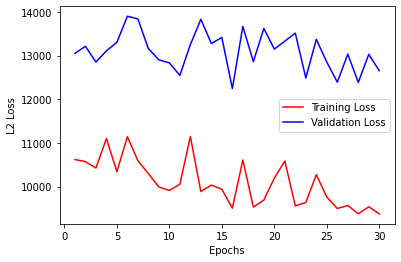


Training Loss :  9372.734803276944

Validation Loss :  12653.52291936679


In [67]:
# Define and train the Deep Neural Network.
MutiValueImputer = DNN()

MutiValueImputer.createDNN(12, 12, [120, 120, 120], out_type='regression', activation='relu', initializer='he')

costs = MutiValueImputer.trainDNN(X_train.T, Y_train, X_val.T, Y_val, optim='adam', regularizer='l2',
                       regularizer_lambda=0.1, mini_batch_size=50, epochs=30, print_loss_freq=10,
                       l_r=0.02)


## Validation {-}

In [68]:
X_Val=pd.read_csv('/Users/harsha/Desktop/myProjects/Fall2020-Local/ML/CS536FinalProject/ML-FinalProject/Datasets/Test_data.csv', encoding = 'ISO-8859-1')
selFeat=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']
X_Val=X_Val[selFeat]
Xarr_val=X_Val.to_numpy()
arr = np.random.binomial(1, 0.5, Xarr_val.shape)
indices=np.where(arr==0)
trueVals=Xarr_val[indices]
Xtransformed=Xarr_val.astype('float')
Xtransformed[indices]=np.nan
Xtest=Xtransformed.copy()
col_mean = np.nanmean(Xtest, axis=0)
#Find indices that you need to replace
inds = np.where(np.isnan(Xtest))
#Place column means in the indices. Align the arrays using take
Xtest[inds] = np.take(col_mean, inds[1])

## Predictions & Analyse {-}

In [46]:
yPredict = MutiValueImputer.predict(Xtest.T)
yPredict=yPredict.T
predict=yPredict[indices]
means=Xtest[indices]
df = pd.DataFrame(data=predict, columns=["Predicted Val"])
df["Original Val of the Feature"]=trueVals
df["Mean Val of the Feature"]=Xtest[indices]
df.head(20)

,Predicted Val,Original Val of the Feature,Mean Val of the Feature
0,-8.612423,-4,-6.725803
1,74.197810,54,-52.263846
2,110.164674,108,104.492345
3,-88.655479,-100,-93.828440
4,-159.369885,-178,-159.575381
5,-9.793653,-14,-6.725803
6,-453.605029,-492,-87.059384
7,-485.116175,-516,-52.263846
8,-179.588697,-187,-167.516708
9,-168.548464,-173,-159.575381


## Important Notes {-}
- The results are pretty fascinating as we can see above although we passed in mean value for the missing value, The imputed value is super close to true value.
- Below we measured the accuracy in terms of score, where score 0 is best and 1 is worse
- Our Neural Net model could give a score of <strong>0.15</strong>
- Basic Completion agent (filling missed values with mean) gives a score of <strong>0.55</strong>, which is not great.

## Score between Original Val vs Predicted Val {-}

In [47]:
score = (((trueVals - predict) ** 2).sum() / ((trueVals - trueVals.mean()) ** 2).sum())
score

0.1587487400975421

## Score between Original Val vs Mean Val {-}

In [48]:
score = (((trueVals - means) ** 2).sum() / ((trueVals - trueVals.mean()) ** 2).sum())
score

0.552920214301927

## Training the Neural Network to Classify the data points {-}
- PsuedoCode:
    1. Train a Neural Network on train data to classify the 5 classes -> Sitting, Standing, Walking, Sitting Down, Standing Up
    2. We read the test data and create a missing value (with missing values filled as mean value of the column) dataset out of that
    3. Use the Multiple Imputation model that we trained above to impute missing values from a test dataset
    4. Use the classifier network to classify authentic dataset and as well as Imputed value dataset
    5. Compare both the predictions and the expectation is we need to see almost same classification accuracy.
    

## Read the Train Data for Neural Network Classifier {-}

In [186]:
X=pd.read_csv('/Users/harsha/Desktop/myProjects/Fall2020-Local/ML/CS536FinalProject/ML-FinalProject/Datasets/Train_data.csv', encoding = 'ISO-8859-1')
#X.head(1)
X.loc[(X.class_sitting == 1),'class_sitting']=1
X.loc[(X.class_sittingdown == 1),'class_sittingdown']=2
X.loc[(X.class_standing == 1),'class_standing']=3
X.loc[(X.class_standingup == 1),'class_standingup']=4
X.loc[(X.class_walking == 1),'class_walking']=5
X['class'] = X['class_sitting'] + X['class_sittingdown']+X['class_standing']+X['class_standingup']+X['class_walking']
X.drop(['class_sitting', 'class_sittingdown', 'class_standing',
       'class_standingup', 'class_walking'], axis=1, inplace=True)
X['class']=X['class'] - 1
selFeat=['age', 'how_tall_in_meters', 'weight', 'body_mass_index', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4', 'user_debora',
       'user_katia', 'user_wallace', 'user_jose_carlos', 'gender_Woman',
       'gender_Man', 'x1']
Xtrain = X[selFeat]
ytrain = X['class']
Xtrain=Xtrain.to_numpy().copy()
ytrain=ytrain.to_numpy().copy()
# X_train=Xtrain[:99379,:].copy()
# X_test=Xtrain[99380:132000,:].copy()
# X_val=Xtrain[132001:132507,:].copy()
# Y_train=ytrain[:99379].copy()
# Y_test=ytrain[99380:132000].copy()
# Y_val=ytrain[132001:132507].copy()
X, X_test, Y, Y_test = train_test_split(Xtrain, ytrain, test_size = 0.25)
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.01)

In [187]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train).T
X_train =(X_train.T-np.mean(X_train.T,axis=0))/np.std(X_train.T,axis=0)
Y_val = to_categorical(Y_val).T
X_val =(X_val.T-np.mean(X_val.T,axis=0))/np.std(X_val.T,axis=0)
Y_test = to_categorical(Y_test).T
X_test =(X_test.T-np.mean(X_test.T,axis=0))/np.std(X_test.T,axis=0)

In [131]:
Y_train.shape, X_train.shape

((5, 98385), (22, 98385))

## Training a Classification Network {-}

After 5 epochs :    Training Loss = 0.2659053645585235    Validation Loss = 1.1069713153538339

		     Training Accuracy = 0.9109315444427504    Validation Accuracy = 0.9074446680080482



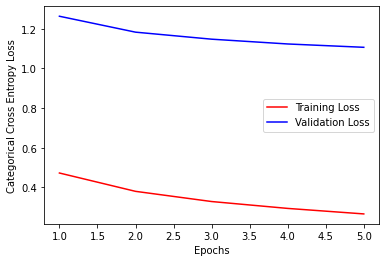


Training Loss :  0.2659053645585235

Validation Loss :  1.1069713153538339

Training Accuracy :  0.9109315444427504

Validation Accuracy :  0.9074446680080482


In [132]:
# Define and train the Deep Neural Network.
ClassificationNet = DNN()
ClassificationNet.createDNN(22, 5, [800], out_type='classification', activation='lrelu', initializer='he',
                slopeLeakyRelu=0.1)

costs = ClassificationNet.trainDNN(X_train, Y_train, X_val, Y_val, optim='adam', regularizer='dropout', keep_probs=[0.75],
                       mini_batch_size=128, epochs=5, print_loss_freq=5, l_r=0.0002)

## Evaluation {-}
- Read Test Data
- Get X1 to Z4 data
- Randomly nan it
- Impute the nan by above multi Imputer
- Replace the columns of original dataset and create a new comparision dataset
- Run prediction on both

## Read the Test Data {-}

In [416]:
X_Val=pd.read_csv('/Users/harsha/Desktop/myProjects/Fall2020-Local/ML/CS536FinalProject/ML-FinalProject/Datasets/Test_data.csv', encoding = 'ISO-8859-1')
selFeat=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']
X_Val=X_Val[selFeat]
Xarr_val=X_Val.to_numpy()
arr = np.random.binomial(1, 0.8, Xarr_val.shape)
indices=np.where(arr==0)
trueVals=Xarr_val[indices]
Xtransformed=Xarr_val.astype('float')
Xtransformed[indices]=np.nan
Xtest=Xtransformed.copy()
col_mean = np.nanmean(Xtest, axis=0)
#Find indices that you need to replace
inds = np.where(np.isnan(Xtest))
#Place column means in the indices. Align the arrays using take
Xtest[inds] = np.take(col_mean, inds[1])

## Using MultiValueImputer imputing values {-}
- Note: The MultiValueImputer values are is the <strong>generated realistic data</strong> for the missing values

In [417]:
Features_Predict = MutiValueImputer.predict(Xtest.T).T

In [419]:
Features_Predict[0]

array([  -7.96601908,   92.06577922,  -90.0087814 ,    1.98002791,
         65.09706742,  -96.56342241,   19.86538019,   93.39111694,
        -86.04187349, -159.80602324,  -91.7844986 , -154.57594403])

In [420]:
Xarr_val=Xarr_val.astype(float)

In [421]:
Xarr_val[indices]=Features_Predict[indices]

In [422]:
Features_Predict=Xarr_val

In [423]:
Features_Predict[0]

array([  -4.        ,   80.        ,  -82.        ,    0.        ,
         54.        , -132.        ,   21.        ,  108.        ,
       -100.        , -159.80602324,  -91.        , -178.        ])

In [424]:
Features_Predict=pd.DataFrame(Features_Predict,columns=['x1', 'y1', 'z1','x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])

## Original Test Data Features

In [425]:
X=pd.read_csv('/Users/harsha/Desktop/myProjects/Fall2020-Local/ML/CS536FinalProject/ML-FinalProject/Datasets/Test_data.csv', encoding = 'ISO-8859-1')
#X.head(1)
X.loc[(X.class_sitting == 1),'class_sitting']=1
X.loc[(X.class_sittingdown == 1),'class_sittingdown']=2
X.loc[(X.class_standing == 1),'class_standing']=3
X.loc[(X.class_standingup == 1),'class_standingup']=4
X.loc[(X.class_walking == 1),'class_walking']=5
X['class'] = X['class_sitting'] + X['class_sittingdown']+X['class_standing']+X['class_standingup']+X['class_walking']
X.drop(['class_sitting', 'class_sittingdown', 'class_standing',
       'class_standingup', 'class_walking'], axis=1, inplace=True)
X['class']=X['class'] - 1
selFeat=['age', 'how_tall_in_meters', 'weight', 'body_mass_index', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4', 'user_debora',
       'user_katia', 'user_wallace', 'user_jose_carlos', 'gender_Woman',
       'gender_Man', 'x1']
Xtest = X[selFeat]
ytest = X['class']

## Replacing X1 though Z4 with predicted values and creating a comparision dataset

In [426]:
XComparision=Xtest.copy()

In [427]:
XComparision[['x1', 'y1', 'z1','x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']]=Features_Predict[['x1', 'y1', 'z1','x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']]

## Evaluating on Original Dataset

In [428]:
XComparision=XComparision.to_numpy().astype(float).copy()

In [429]:
Xtest=Xtest.to_numpy().astype(float).copy()

In [430]:
Xtest.shape

(33127, 22)

In [431]:
XComparision[0]

array([  46.        ,  162.        ,   75.        ,   28.6       ,
         80.        ,  -82.        ,    0.        ,   54.        ,
       -132.        ,   21.        ,  108.        , -100.        ,
       -159.80602324,  -91.        , -178.        ,    1.        ,
          0.        ,    0.        ,    0.        ,    1.        ,
          0.        ,   -4.        ])

In [432]:
Xtest[0]

array([  46. ,  162. ,   75. ,   28.6,   80. ,  -82. ,    0. ,   54. ,
       -132. ,   21. ,  108. , -100. , -179. ,  -91. , -178. ,    1. ,
          0. ,    0. ,    0. ,    1. ,    0. ,   -4. ])

In [433]:
Xtest =(Xtest.T-np.mean(Xtest.T,axis=0))/np.std(Xtest.T,axis=0)

In [434]:
Xtest.shape

(22, 33127)

In [435]:
Y_pred = ClassificationNet.predict(Xtest)

In [436]:
Y_pred.shape

(5, 33127)

In [437]:
ytest = to_categorical(ytest).T

In [438]:
ytest.shape

(5, 33127)

In [440]:
print("Accuracy yield on Original Data: ",np.round(ClassificationNet.accuracy(Y_pred,ytest)*100,2),"%")

Accuracy yield on Original Data:  90.65 %


## Testing on Missing Value Imputed Data

In [441]:
XComparision =(XComparision.T-np.mean(XComparision.T,axis=0))/np.std(XComparision.T,axis=0)

In [442]:
XComparision.shape

(22, 33127)

In [443]:
Y_pred_synth = ClassificationNet.predict(XComparision)

In [444]:
print("Accuracy yield on Synthetic Data: ",np.round(ClassificationNet.accuracy(Y_pred_synth,ytest)*100,2),"%")

Accuracy yield on Synthetic Data:  86.03 %


## Observations {-}
- The Classification accuracy with Original data is <strong>90.65%</strong>
- The Classification accuracy with Missing Values replaced by the MultiValue Imputer Neural Network is giving an accuracy of <strong>86.3%</strong> which is pretty close to true data's classification accuracy.

## Saving the model

In [272]:
import pickle

In [274]:
pickle.dump(model, open('NN_MultiImpute.pkl','wb'))